Wavelet Domain Image Watermarking
=================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_matlab/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


This numerical tour explores robust watermarking  over the wavelet
domain.


Many thanks to Patrick Bas and Teddy Furon for their useful advices on digital image
watermarking.

In [1]:
addpath('toolbox_signal')
addpath('toolbox_general')
addpath('solutions/coding_5_watermarking')

Digital Image Watermarking
--------------------------
Digital media watermarking is a popular image forensic problem. It
requires to embed a signature into a sound, image, video, 3D mesh, etc.


An good source of information regarding digital watermarking is the book


_Digital Watermarking and Steganography, 2nd Ed_,
Ingemar J. Cox, Matthew L. Miller, Jeffrey Bloom,
Morgan Kaufmann, 2007.


One can also visit the <http://bows2.gipsa-lab.inpg.fr/ BOWS-2> challenge
homepage for a state of the art digital watermarking implementation.


We consider here a robust watermarking embedding, i.e. the goal
is to embed a watermark that is both impercevable and difficult to remove
(by attack such as compression, denoising, adding noise, blurring, etc).


This is somehow conflicting goals since impercevable information is likely
to be removed by an efficient compression or denoising algorithm.
An efficient watermarking scheme should thus use more clever tools than
state of the art denoising/compression algorithms.


Note also that we perform here "0 bit" watermarking, i.e. we do not
embed a meaningful message within the watermarking. We are only
interested in testing the presence of a given watermark.


Here we bench a wavelet method for the embedding of a single
watermark. We check how much the watermark can be detected after
various attack.
Depending on a probability of false alarm, we compute the
probability of detecting the watermark.


Watermark Embedding
-------------------
A watermark is computed as a weighted random vector that is added to the
wavelet coefficient.


The weighting of the watermark vector takes into account the amplitude of
the host coefficient in order to reduce visual distortion. This also
increases the robustness to denoising and compression attacks.



Load an image $f \in \RR^N$ of $N = n \times n$ pixels.

In [2]:
n = 256;
name = 'hibiscus';
f = load_image(name, n);
f = rescale(sum(f,3));

Display the original image.

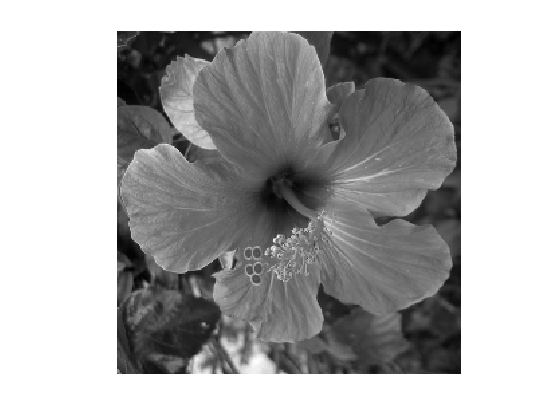

In [3]:
clf;
imageplot(f);

Shortcut for the wavelet transform $\Psi : f \in \RR^N \mapsto a \in \RR^N$
that maps an image $f$ to wavelet coefficients $a$.
We note its inverse $\Psi^{-1}$ using the shortcut |PsiS|.

In [4]:
Jmin = log2(n)-2;
Psi  = @(f)perform_wavelet_transf(f, Jmin, +1);
PsiS = @(a)perform_wavelet_transf(a, Jmin, -1);

Compute the wavelet coefficients.

In [5]:
a = Psi(f);

Display the wavelet coefficients.

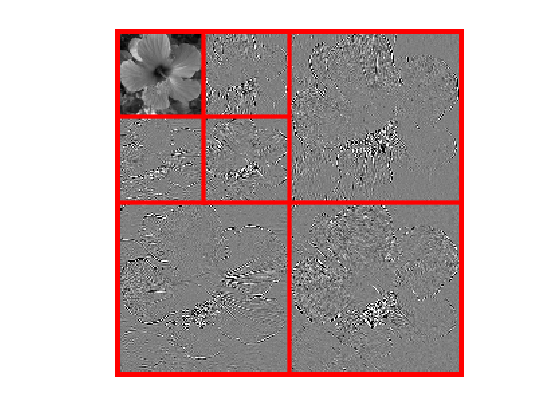

In [6]:
clf;
plot_wavelet(a,Jmin);

The coefficients to be watermarked $x_0 \in \RR^P $ is only a subset
$ x_0 = (a_i)_{i \in I} $ of the total set of coefficients, where
$\abs{I}=P$.


We select here only the fine scale wavelets.

In [7]:
A = ones(n); A(1:2^Jmin,1:2^Jmin) = 0;
I = find(A(:));
P = length(I);

Extract the coefficients $x_0$.

In [8]:
x0 = a(I);

The watermarking is embedded using a multiplicative rule as
$$ x_i = (x_0)_i + \rho \abs{ (x_0)_i } w_i  $$
where $w$ is a random Gaussian vector and
where $\rho > 0$ is a constant that ensure that $\norm{x_0-x}$ is a given
deviation value.


Generate the base watermark vector $w \in \RR^P$.

In [9]:
w = randn(P,1);

Target embedding PSNR (should be quite large for the embedding to be
unoticeable).

In [10]:
psnr_embedding = 50;

__Exercise 1__

Compute |rho| so that |PSNR(y,x0,1)=snr_embedding|.

In [11]:
exo1()

rho = 0.0795.

In [12]:
%% Insert your code here.

__Exercise 2__

According to you, for which PSNR the watermark becomes unoticeable?

In [13]:
exo2()

In [14]:
%% Insert your code here.

Perform the embedding $x=x_0+\rho\abs{x_0}w$.

In [15]:
x = x0 + rho*abs(x0).*w;

The distortion of the embedding is measured using the PSNR
$$ \text{PSNR}(x,x0) = -20 \log_{10}( \norm{x-x0}/\sqrt{P} ). $$


Check the PSNR of embedding.

In [16]:
disp(['PSNR(x,x0) = ' num2str(psnr(x,x0,1), 3) 'dB.']);

PSNR(x,x0) = 50dB.

Given the watermarked coefficients $x \in \RR^P$,
a watermarked image $f_1 \in \RR^N$ is reconstructed
using the inverse wavelet transform $\Psi^{-1}$ as
$$ f_1 = \Psi^{-1}(a_1) \qwhereq
  (a_1)_i = \choice{ x_i \qifq i \in I, \\ a_i \quad\text{otherwise.} }$$


Compute the image with the watermark embedded.

In [17]:
a1 = a; a1(I) = x;
f1 = PsiS(a1);

Display the watermark $ \delta = \Psi^{-1}(a-a_1) = f - f_1 $ over the
spacial domain (with contrast boosting).

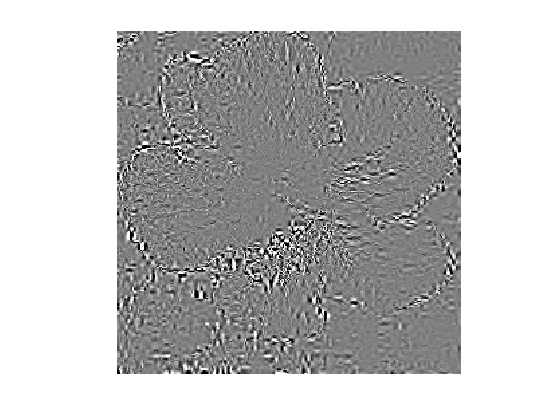

In [18]:
delta = f-f1;
clf;
imageplot( clamp(delta/std(delta(:)),-3,3) );

Watermark Detection
-------------------
The watermark is detected (or not detected) from an input vector $y \in \RR^P$
using a detector function $C(y,w) \in \RR$ where $w \in \RR^P$ is the
base watermark vector. Usually, a large value of $C$ means that $y$
is likely to come from a watermarked content.


The detection is carried over by a simple thresholding, and the watermark
is declared to be present if
$$ C(y,w)>T  $$
where $T \in \RR$ is a threshold that should be set to guarantee a
given  probability of false alarms (i.e. ratio of contents declared to be
watermarked whereas they were not watermarked).


The detection corresponds to an hypothesis testing. One assumes that $y=A(x)$
is obtained by attacking some vector $x$, and one has the following
alternative depending on wether the content $x$ is watermarked or not:
$$ \choice{ (\Hh_0) \quad x=x_0+\rho\abs{x_0}w, \\ (\Hh_1) \quad x=x_0. } $$


The two important quantities to monitor is the probability of false alarms
$$ p_{\text{FA}} = \PP_w\pa{ C(y,w)>T \:\vert\: \Hh_1 } $$
and the probability of true positives
$$ p_{\text{TP}} = \PP_w\pa{ C(y,w)>T \:\vert\: \Hh_0 }. $$
Note that here $\PP_w$ refers to the probability of an event with respect to
the randomization of $w$.


The goal is to design a watermarking scheme (i.e. an embedding strategy
and a detection strategy) in order to maximize $p_{\text{TP}}$
for a given $p_{\text{FA}}$.


The simplest detector is a normalized correlation
$$ C(y,w) = \frac{\dotp{y}{w}}{\norm{y}\norm{w}}. $$

In [19]:
C = @(y,w)sum(w.*y)./sqrt( sum(w.^2).*sum(y.^2) );

To estimate easily the probability of false alarm, we make the asumption
that $y$ is close enough to $x_0$ to estimate $p_{\text{FA}}$ on
the clean original signal
$$ p_{\text{FA}} \approx \PP_w( C(x_0,w)>T ) $$

__Exercise 3__

Using a Monte Carlo simulation (generation of the order of $10^3$
watermarks, display the histogram of the repartition of $C(x_0,w)$.
Compute the variance $\sigma_0^2$ of this distribution.

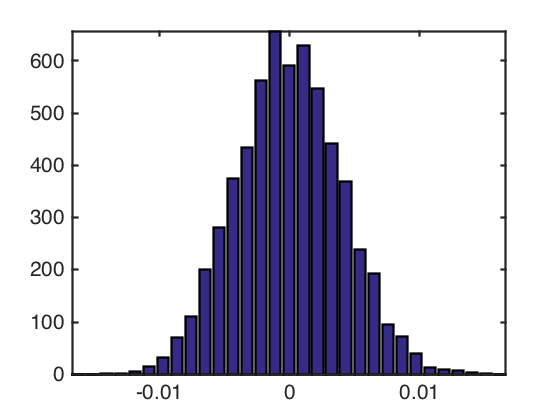

In [20]:
exo3()

In [22]:
%% Insert your code here.

We make another approximation : we approximate this density probability
with a Gaussian density of mean 0 and variance $\si_0^2$. Under this
assumption, one has
$$ p_{\text{FA}} \approx 1 - G_{\si_0}(T)
 = 1 - \frac{1}{2} \pa{ 1 + \text{erf}\pa{\frac{T}{\sqrt{2} \si_0}} } $$
where $G_{\si_0}$ is the cumulative density function of the Gaussian of
variance $\si_0^2$.


Hence one can use the threshold
$$ T = \sqrt{2} \sigma_0 \text{erf}^{-1}(1-2 p_{\text{FA}}) $$
This is an example of determination of threshold $T$ given a value of
$ p_{\text{FA}} $.

In [23]:
pfa = 1e-3;
T = sqrt(2)/2 * sigma0 * erfinv(1-2*pfa);

Actually, it is possible to compute exactly this probability of false
alarm as
$$ p_{\text{FA}} = 1 - B(T^2 ; 1/2, (P-1)/2),  $$
where $B$ is the incomplete beta function (use |betainc| function) and $P$ is the dimension.

__Exercise 4__

Compare, for various values of $T$ the estimation obtained by
the Gaussian approximation with the true value obtained with the
incomplete beta function.

In [24]:
exo4()

In [25]:
%% Insert your code here.

Quantization Attack
-------------------
A compression attack is simulated by quantizing the wavelet coefficients.
We consider here a dead zone quantization attack.


Quantization step $\tau$ (the larger, the more aggressive the compression.

In [26]:
tau = .2;

A quantization attack reads:
$$ A() = \text{sign}(v) (\abs{v} + 1/2)  \tau
 \qwhereq v = \lfloor \frac{\abs{x}}{\tau} \rfloor \text{sign}(x)  $$


Quantization/Dequantization operators, and attack operator.

In [27]:
Quant = @(x)floor(abs(x/tau)).*sign(x);
DeQuant = @(v)sign(v) .* (abs(v)+.5) * tau;
A = @(x)DeQuant(Quant(x));

Display it.

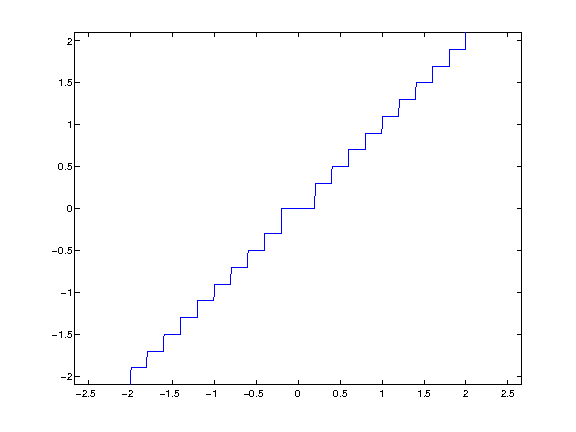

In [28]:
t = linspace(-2,2,500);
plot(t, A(t));
axis('equal');

Attacked watermarked signal

In [29]:
y = A(x);

Display the attacked image.

In [30]:
a1 = a; a1(I) = y;
f1 = PsiS(a1);

Display the watermarked image.

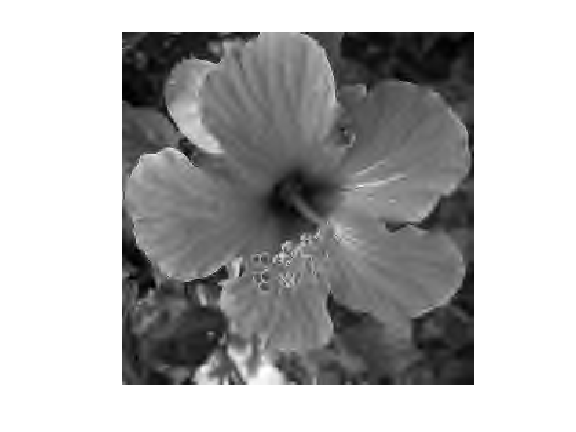

In [31]:
clf;
imageplot(clamp(f1));

Compute the detection $C(y,w)$.

In [32]:
disp(['C(y,w) = ' num2str(C(y,w), 2) '.']);

C(y,w) = 0.019.


The probability of true positive is
$$ p_{\text{TP}} = \PP_w\pa{ C(A(x_0 + \rho\abs{x_0}w),w)>T  }. $$

__Exercise 5__

Compute, by Monte Carlo sampling (i.e. draw at random many $w$)
the distribution of $C(A(x),w)$ for $x = x_0 + \rho \abs{x_0} w$. Store the different realization of
$C(A(x),w)$ in a vector |c|.
_Note:_ the value of $\rho$ should
be recomputed for each $w$.

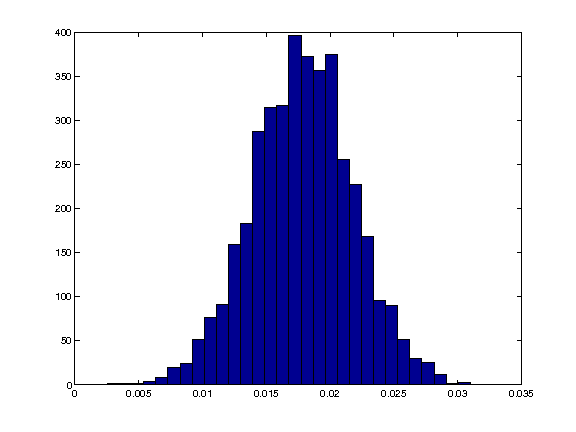

In [33]:
exo5()

In [34]:
%% Insert your code here.

__Exercise 6__

Compute, for a varying value of $ p_{\text{FA}} $, the corresponding
value of $ p_{\text{TP}} $. Display the resulting curve (ROC curve).
This computation should be performed experimentally
using e.g. 1000 random sampling.

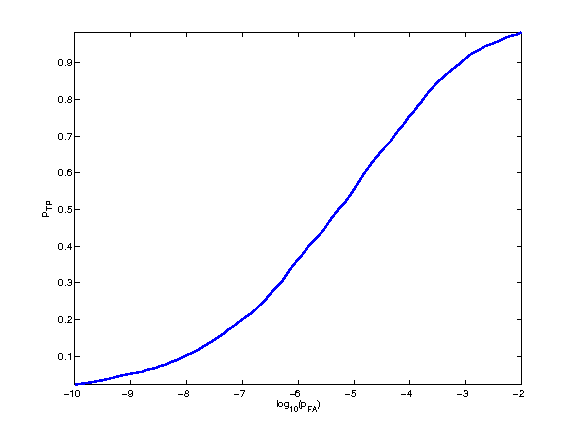

In [35]:
exo6()

In [36]:
%% Insert your code here.

__Exercise 7__

Try different attack strengths, by changing the value of $\tau$.
For a $p_{\text{FA}}=10^{-6}$, determine the value of $\tau$
for witch $p_{\text{TP}}$ drops bellow $0.2$.

In [37]:
exo7()

In [38]:
%% Insert your code here.

__Exercise 8__

Try different attacks, for instance on the image itself (blurring,
denoising, etc.).

In [39]:
exo8()

In [40]:
%% Insert your code here.